In [2]:
import geometry
import scale_transform
import numpy as np
import matplotlib.pyplot as plt
import cv2
import json
import platonics

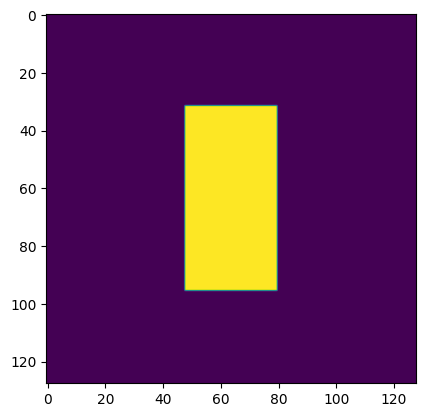

In [3]:
# test case: 128*128*128 matrix with 64^3 in the center
num_slices = 5

test_1 = np.zeros((128, 128, 128))
test_1[32:96, 48:80, 32:96] = 200
test_2=np.ones((128,128,128))
for i in range(128):
    for j in range(128):
        for k in range(128):
            if ((i-64)**2+(j-64)**2+(k-64)**2)**0.5>50:
                test_2[i,j,k]=0
                
plt.imshow(test_1[:,:,64])

In [4]:
angle_list = [(0,0,0), (np.pi/2,0,0), (0,np.pi/2,0), (0,0,np.pi/2), (np.pi/4,0,0), (0,np.pi/4,0), (0,0,np.pi/4), (np.pi/8,0,0), (0,np.pi/8,0), (0,0,np.pi/8)]
transform_list = []
slices_list = []

for a in angle_list:
    transform_list.append(geometry.Transform(a, translation=(0, 0, 0)))

for a, t in enumerate(transform_list):
    transformed_img = scale_transform.global_to_local(test_1, t)
    slice_transformed_img = transformed_img[:,:,transformed_img.shape[2]//2]
    cv2.imwrite(f'slices_for_prompting/slice_{a}.png', slice_transformed_img)

    slice_info = dict()
    slice_info['idx'] = transformed_img.shape[2]//2
    slice_info['transform'] = t
    slice_info['shape'] = transformed_img.shape
    slices_list.append(slice_info)



In [5]:
len(angle_list)

10

In [6]:


# load image files and save prompt points



In [7]:
# get test matrix

# get the list of transforms

# slice the matrix using global_to_local function. Do it to every transform.

# Add prompting:
    # save slices to image files (naming convention: 001.png)
    # open image files and save prompt points to jason 

# convert prompt points to zero_centric coordinates using index_to_coord

# for each transform:
    # calculate the rotated array
    # for n slices:
        # get the slice of the rotated array,
        # calculate the prompts intersecting with that slice
        # feed into SAM inference function
        # Get mask points for that slice
        # Convert to global coord, append to list of global mask points
        
# take global mask points, convert to volumetric mask

In [8]:
# parsing
with open('test_data.json', 'r') as file:
    prompt_points = json.load(file)
pos_polylines_slices = []
neg_polylines_slices = []

for prompt in prompt_points:
    pos_polylines_slices.append(prompt['pos_polylines'])
    neg_polylines_slices.append(prompt['neg_polylines'])

In [9]:
# get pos, neg line segments
pos_seg = []
neg_seg = []

for i, s in enumerate(slices_list):
    idx = s['idx']
    shape = s['shape']
    transform_curr = s['transform']

    for line in pos_polylines_slices[i]:
        global_line = []
        for point in line:
            scaled_point = scale_transform.scale_forward(point[:2] + [idx], shape)
            transformed_point = scale_transform.coord_to_index(scaled_point, transform_curr, shape)
            global_line.append(transformed_point)
        for i in range(len(global_line) - 1):
            pos_seg.append([global_line[i], global_line[i + 1]])

    for line in neg_polylines_slices[i]:
        global_line = []
        for point in line:
            scaled_point = scale_transform.scale_forward(point[:2] + [idx], shape)
            transformed_point = scale_transform.coord_to_index(scaled_point, transform_curr, shape)
            global_line.append(transformed_point)
        for i in range(len(global_line) - 1):
            neg_seg.append([global_line[i], global_line[i + 1]])


In [10]:
# convert prompt points to zero_centric coordinates using index_to_coord

prompting_slices_dict = dict()
count = 0

for t in transform_list:
    transformed_img = scale_transform.global_to_local(test_1, t)
    matrix_shape = transformed_img.shape
    
    z_coord_list = np.linspace(0, transformed_img.shape[2], num_slices + 1, endpoint=False, dtype=int)[1:]  

    for z in z_coord_list:
        # get the slice of the rotated array
        slice_transformed_img = transformed_img[:,:,z]
        slice_shape = slice_transformed_img.shape
        
        # calculate intersection points
        pos_intersects = []
        neg_intersects = []

        for p in pos_seg:
            point_1 = scale_transform.scale_backward(scale_transform.index_to_coord(p[0], t, matrix_shape), matrix_shape)
            point_2 = scale_transform.scale_backward(scale_transform.index_to_coord(p[1], t, matrix_shape), matrix_shape)

            intersection = scale_transform.get_intersection_point(point_1, point_2, z)
            if intersection:
                pos_intersects.append(intersection[:2])

        for n in neg_seg:
            point_1 = scale_transform.scale_backward(scale_transform.index_to_coord(n[0], t, matrix_shape), matrix_shape)
            point_2 = scale_transform.scale_backward(scale_transform.index_to_coord(n[1], t, matrix_shape), matrix_shape)

            intersection = scale_transform.get_intersection_point(point_1, point_2, z)
            if intersection:
                neg_intersects.append(intersection[:2])

        print(pos_intersects, neg_intersects)

        if len(pos_intersects) != 0:
            prompting_slices_dict[count] = {'image': slice_transformed_img, 'pos': pos_intersects, 'neg': neg_intersects}
            count += 1
        # prompting_slices_dict[slice_transformed_img] = (pos_intersects, neg_intersects)

        # feed into SAM inference function``


[] [(110.0, 169.44736842105263), (113.44444444444444, 109.0), (165.04545454545453, 109.0)]
[] [(109.84269662921348, 187.0), (109.89887640449439, 22.640449438202246), (146.0, 185.92592592592592), (146.0, 30.57894736842105)]
[(110.0, 98.66666666666669), (107.0, 110.0), (118.14285714285715, 110.0), (109.0, 131.0), (109.0, 73.0), (111.0, 110.0), (107.6, 104.0), (108.0, 124.5), (118.00000000000001, 109.71428571428572)] [(109.42696629213484, 187.0), (109.48314606741573, 37.60674157303371), (109.0, 187.0), (109.0, 37.58064516129032), (107.8, 170.175)]
[] [(109.02247191011236, 187.0), (109.07865168539325, 52.168539325842694), (56.89473684210526, 110.0), (73.0, 149.0)]
[] [(165.24137931034483, 110.0), (70.52631578947368, 110.0)]
[] [(169.44736842105263, 110.00000000000001), (109.00000000000001, 106.55555555555554), (109.00000000000001, 54.95454545454544)]
[] [(187.0, 110.15730337078654), (22.640449438202246, 110.10112359550558), (185.92592592592595, 74.00000000000003), (30.578947368421066, 73.9

In [11]:
len(prompting_slices_dict)

11

the notebook we will use


